### Purpose of this notebook

In [570]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import scipy.stats as st
import matplotlib.cm as cm
#from IPython.display import JSON
import math
import inspect
from typing import List, Dict, Optional

### Functions

In [571]:
def show_df_info(df: pd.DataFrame) -> pd.DataFrame:
    """
    Prints information about a DataFrame, including column names, data types, and non-null counts.
    
    Args:
        df (pandas.DataFrame): The DataFrame to process.
        
    Returns:
        pandas.DataFrame: A DataFrame containing the column names, data types, and non-null counts, and null counts of the input DataFrame.
    """
    col_names = df.columns.to_list()
    col_dtypes = df.dtypes.to_list()
    non_null_counts = df.count().to_list()
    null_counts = df.isnull().sum().to_list()
    info_df = pd.DataFrame({'column_name': col_names, 'dtype': col_dtypes, 'non_null_count': non_null_counts, 'null_count': null_counts})

    caller_frame = inspect.currentframe().f_back
    df_name = [var_name for var_name, var_val in caller_frame.f_locals.items() if var_val is df][0]

    print(f"DataFrame '{df_name}' has {len(df)} rows and {len(df.columns)} columns.")
    print("Here is a summary of the column names, data types and null counts:")
    return info_df

In [572]:
def get_unique_links(df):
    #unique_links = df['link'].unique()
    unique_links = df['link'].unique().tolist()
    return unique_links

In [573]:
def get_nonunique_links(df):
    #nonunique_links = df[df.duplicated(['link'])]
    #nonunique_links = df[df.duplicated(['link'])]['link']
    nonunique_links = df[df.duplicated(['link'])]['link'].tolist()
    return nonunique_links

In [574]:
def multiplotv_dark(df: pd.DataFrame, filter_col: str = None, fmin: float = None, fmax: float = None) -> None:
    """
    Generate a set of 4 plots to visualize the relationship between two variables in a DataFrame.
    :param df: DataFrame containing the data
    :param filter_col: Name of the column to filter on (optional)
    :param filter_min: Minimum value for the filter_col (optional)
    :param filter_max: Maximum value for the filter_col (optional)
    """

    # define subplots
    face_color = '0.1'
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16, 12), facecolor=face_color)
    
    # Set background color to black
    #plt.style.use('dark_background')

    # apply filter and subtitle
    if filter_col:
        if fmin is not None and fmax is not None:
            if fmin < fmax:
                fig.text(0.5, 0.94, f'Filtered on {fmin} < {filter_col} < {fmax}', ha='center', fontsize=16, color='white')
                df = df[(df[filter_col] <= fmax) & (df[filter_col] >= fmin)]
            else:
                fmin, fmax = fmax, fmin
                fig.text(0.5, 0.94, f'Filtered on {fmin} > {filter_col} > {fmax}', ha='center', fontsize=16, color='white')
                df = df[(df[filter_col] >= fmax) | (df[filter_col] <= fmin)]
        elif fmin is not None and fmax is None:
            fig.text(0.5, 0.94, f'Filtered on {filter_col} > {fmin}', ha='center', fontsize=16, color='white')
            df = df[df[filter_col] >= fmin]
        elif fmin is None and fmax is not None:
            fig.text(0.5, 0.94, f'Filtered on {filter_col} < {fmax}', ha='center', fontsize=16, color='white')
            df = df[df[filter_col] <= fmax]
        else:
            print(f'Warning: you must provide a min and/or max on which to filter on {filter_col} or no filtering will occur')

    # apply main title
    main_title = f'Correlation Study: Rank vs Percent Human ({len(df)} data points)'
    fig.suptitle(main_title, fontsize=20, fontweight='bold', y=.98, color='white')
    
    
    # Fig 1: Q-Q plot [0, 0]
    st.probplot(df['percent_human'], dist='norm', plot=axs[0, 0])
    axs[0, 0].set_title('Figure 1: Q-Q Plot of Percent Human')
    axs[0, 0].set_xlabel('Theoretical quantiles')
    axs[0, 0].set_ylabel('Sample quantiles')
    axs[0, 0].text(0.02, 0.95, 'Data is not normally distributed\nand cannot be evaluated using Pearson\'s method', transform=axs[0, 0].transAxes, fontsize=12, verticalalignment='top', color='white')

    
    # Fig 2: Histogram [0, 1]
    sns.histplot(data=df['percent_human'], kde=False, binwidth=1, color='green', ax=axs[0, 1], edgecolor='grey')
    axs[0, 1].set_title('Figure 2: Histogram of Percent Human')
    axs[0, 1].set_xlabel('Percent Human')
    axs[0, 1].set_ylabel('Count')
    axs[0, 1].set_xlim(-5, 105)
    axs[0, 1].set_ylim(0, None)
    skewness = round(st.skew(df['percent_human']), 2)
    axs[0, 1].text(0.02, 0.95, f'Data Skewness {skewness}', transform=axs[0, 1].transAxes, fontsize=12, verticalalignment='top', color='white')
    #axs[0, 1].text(0.02, 0.90, f'Over 1/3 of data in top 2%', transform=axs[0, 1].transAxes, fontsize=12, verticalalignment='top', color='black')

    
    # Fig 3: Violin plot [1, 0]
    sns.violinplot(ax=axs[1, 0], data=df, x="rank", y="percent_human", scale="count", inner="box", color="#00aa00", saturation=0.5, cut=0, linewidth=.9)

        # plot mean lines
    for i, mean in enumerate(df.groupby("rank")["percent_human"].mean()):
        axs[1, 0].hlines(mean, i-0.25, i+0.25, linewidth=1, color='#bbbbbb', zorder=100)

        # plot median markers
    median_markers = df.groupby('rank')['percent_human'].median()
    sns.scatterplot(ax=axs[1, 0], x=median_markers.index-1, y=median_markers.values, marker='o', s=20, color='white', edgecolor='black', zorder=100)
    
    axs[1, 0].set_title('Figure 3: Percent Human vs Rank')
    axs[1, 0].set_xlabel('Rank')
    axs[1, 0].set_ylabel('Percent Human')

   
    # Fig 4: Scatter plot [1, 1]
    grouped_data = df.groupby('rank')
    mean_percent_human = grouped_data['percent_human'].mean().reset_index()
    sns.scatterplot(ax=axs[1, 1], data=mean_percent_human, x='rank', y='percent_human',  color='green', edgecolor=None)
    sns.regplot(ax=axs[1, 1], data=mean_percent_human, x='rank', y='percent_human', color='green', scatter=False, line_kws={'linestyle':'--'})
    axs[1, 1].set_title('Figure 4: Mean Percent Human vs Rank')
    axs[1, 1].set_xlabel('Rank')
    axs[1, 1].set_ylabel('Mean Percent Human')
    axs[1, 1].set_xticks(np.arange(1, 21))
    axs[1, 1].legend(handles=axs[1, 1].lines[::len(mean_percent_human)], labels=['Best fit line'], facecolor=face_color, labelcolor='white')
    axs[1, 1].text(0.02, 0.05, f'Percent Human is weakly correlated to Rank with a high degree of certainty', transform=axs[1, 1].transAxes, fontsize=10, verticalalignment='top', color='white')

        # Calculate correlation coefficients and p-values
    pb_corr, pb_pval = st.pointbiserialr(df['rank'], df['percent_human'])
    spearman_corr, spearman_pval = st.spearmanr(df['rank'], df['percent_human'])
    kendall_tau, kendall_pval = st.kendalltau(df['rank'], df['percent_human'])

        # Create a dictionary to store the results
    corr = {
        'Method': ['Point Biserial', 'Spearman', 'Kendall'],
        'Corr Coef': [pb_corr, spearman_corr, kendall_tau],
        'P-value': [pb_pval, spearman_pval, kendall_pval]
    }

        # Create a pandas dataframe from the corr dict
    df_corr = pd.DataFrame(corr)

        # Create a table to display the correlation coefficients and p-values
    table_data = [list(df_corr.columns)] + df_corr.values.tolist()
    table = axs[1, 1].table(cellText=table_data,
                    colLabels=None,
                    cellLoc='center',
                    bbox=[0.02, 0.08, 0.5, 0.15],  # x, y, width, height
                    cellColours=[[face_color]*3] + [[face_color]*3]*len(df_corr))
    table.set_fontsize(10)
    for cell in table.get_celld().values():
        cell.set_linewidth(0)
        cell.set_edgecolor('none')
        cell.set_text_props(color='white')


        # Format the table to use 4 significant figures
    for i in range(1, len(table_data)):
        for j in range(1, 3):
            cell = table.get_celld()[i, j]
            cell_text = cell.get_text().get_text()
            cell_text = float(cell_text)
            cell_text = f'{cell_text:.4g}'
            cell.get_text().set_text(cell_text)
            #cell.set_edgecolor('white')
    
    font_color = '#cccccc'
    for ax in axs.flat:
        ax.tick_params(axis='x', labelsize=12, colors=font_color)
        ax.tick_params(axis='y', labelsize=12, colors=font_color)
        ax.set_xlabel(ax.get_xlabel(), fontdict={'fontsize': 14, 'color': font_color})
        ax.set_ylabel(ax.get_xlabel(), fontdict={'fontsize': 14, 'color': font_color})
        ax.set_title(ax.get_title(), fontdict={'fontsize': 16, 'color': 'white'})
        ax.set_facecolor(face_color)
        for spine in ax.spines.values():
            spine.set_edgecolor('white')
            #spine.set_linewidth(2)
    
    # shrink outer margin
    fig.subplots_adjust(left=0.05, right=0.95, top=.90, bottom=0.05)
   
    fig.savefig('figures/Fig_1-4.png')
    plt.show()

In [575]:
def get_highest_kw_per_link(df, links):
    highest_kw_per_link = list()
    for link in links:
        # Select rows with the given link
        link_df = df[df['link'] == link]
        # Count the number of occurrences of each 'kw' value
        kw_counts = link_df['kw'].value_counts()
        # Get the highest 'kw' value, or None if there are no 'kw' values
        highest_kw = kw_counts.index[0] if len(kw_counts) > 0 else None
        # Append the highest 'kw' value for this link to the output list
        highest_kw_per_link.append(highest_kw)
    return highest_kw_per_link

In [576]:
def hist_subplot(df, col, sd=1, dark_mode=False, ax=None):
    
    title_fontsize = 20
    label_fontsize = 16
    tick_fontsize = 16
    
    if dark_mode:
        facecolor = '0.1'
        color1 = '#B3B3B3'
        color2 = 'green'
        color3 = 'red'
    else:
        facecolor = 'white'
        color1 = '#051D40'
        color2 = '#55aeff'
        color3 = '#FF5757'
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6), facecolor=facecolor)
    else:
        fig = ax.get_figure()
       
    mean_val = df[col].mean()
    sd_val = df[col].std() * sd
    bin_edges = np.arange(np.floor(df[col].min()) - 0.5, np.ceil(df[col].max()) + 0.5, 1)
    sns.histplot(data=df[col], kde=False, bins=bin_edges, color=color2, ax=ax, edgecolor=color1)
    ax.set_xlabel("", color=color1, fontsize=label_fontsize)
    ax.set_ylabel("", color=color1, fontsize=label_fontsize)
    ax.set_title(col, color=color1, fontsize=title_fontsize, fontweight='bold')
    max_y = df[col].max()
    ax.set_xlim(-0.5, max_y + 0.5)
    ax.set_ylim(0, None)
    ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

    if sd:
        ax.axvline(x=mean_val, color=color3)
        ax.axvline(x=mean_val + sd_val, color=color3, linestyle='--')
        ax.axvline(x=mean_val - sd_val, color=color3, linestyle='--')
        ax.legend([f"Mean {mean_val:.1f}", f"SD ±{sd_val:.1f}"], loc='upper left', facecolor=facecolor, edgecolor=color1)

        for text in ax.legend_.get_texts():
            text.set_color(color1)
    
    ax.set_facecolor(facecolor)
    for spine in ax.spines.values():
        spine.set_edgecolor(color1)
        
    ax.tick_params(axis='x', colors=color1, labelsize=tick_fontsize)
    ax.tick_params(axis='y', colors=color1, labelsize=tick_fontsize)
    
    return fig, ax

In [583]:
def plot_2x2_subplots(specs, title=None):
    if len(specs) != 4:
        raise ValueError("The 'specs' list must contain exactly 4 tuples.")
    
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 12), facecolor='0.1' if specs[0][3] else 'white')
    for idx, ax in enumerate(axes.flatten()):
        hist_subplot(*specs[idx], ax=ax)
    
    if title is not None:
        fig.suptitle(f"{title} Frequency vs. Score", fontsize=28, fontweight='bold', color='#B3B3B3' if specs[0][3] else '#051D40', y=1)
    
    fig.tight_layout()
    plt.show()


### Execution

In [578]:
df = pd.read_csv('data/combined_final.csv')
df.tail(1)
df = df.drop(columns={'text', 'link'})
df.head(1)
#df = df.drop(columns={'hcs', 'aics'})

,smog,cole,auto,dale,pows,forc,spac,gunn,fleG2,fleS,rank,word_count,hcs,aics
0,12.0,12.0,12.0,10.0,16.2,16.3,5.0,13.2,12.0,23.5,15,200.0,89.878726,10.121275


In [579]:
rename_dict = {'smog': 'Smog Index', 'cole': 'Coleman-Liau Index', 'auto': 'Automated Readability Index', 'dale': 'Dale-Chall Index', 'pows': 'Powers-Sumner-Kearl Index', 'forc': 'FORCAST Grade', 'spac': 'Spache Readability Grade', 'gunn': 'Gunning-Fog Index', 'fleG2': 'Flesch-Kincaid Grade', 'fleS': 'Flesch Reading Ease Index'}
df = df.rename(columns=rename_dict)

In [580]:
new_order = ['rank', 'Flesch Reading Ease Index', 'Gunning-Fog Index', 'FORCAST Grade', 'Dale-Chall Index', 'Powers-Sumner-Kearl Index','Automated Readability Index', 'Flesch-Kincaid Grade', 'Coleman-Liau Index', 'Smog Index', 'Spache Readability Grade', 'word_count', 'aics', 'hcs']
df = df.reindex(columns=new_order)

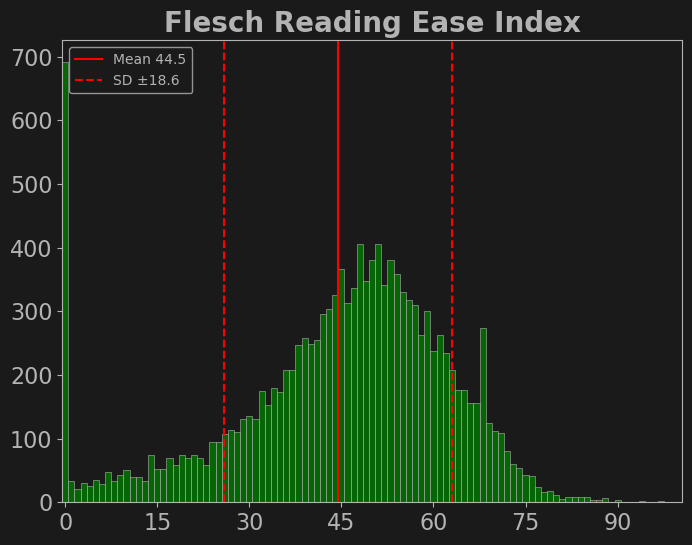

In [581]:
col = 'Flesch Reading Ease Index'
fig, ax = hist_subplot(df, col, sd=1, dark_mode=True)
plt.show()

In [582]:
# def plot2x2(df, cols, sd=1, dark_mode=False):
#     if dark_mode:
#         facecolor = '0.1'
#         color1 = '#B3B3B3'
#         color2 = 'green'
#         color3 = 'red'
#     else:
#         facecolor = 'white'
#         color1 = '#051D40'
#         color2 = '#55aeff'
#         color3 = '#FF5757'

#     fig, axs = plt.subplots(2, 2, figsize=(10, 10), facecolor=facecolor)
#     fig.suptitle('Histogram Subplots', color=color1, fontsize=16)

#     for i, col in enumerate(cols):
#         row = i // 2
#         col = i % 2
#         hist_subplot(df, cols[i], sd, dark_mode=dark_mode, ax=axs[row, col])
    
#     fig.tight_layout()
#     return fig, axs

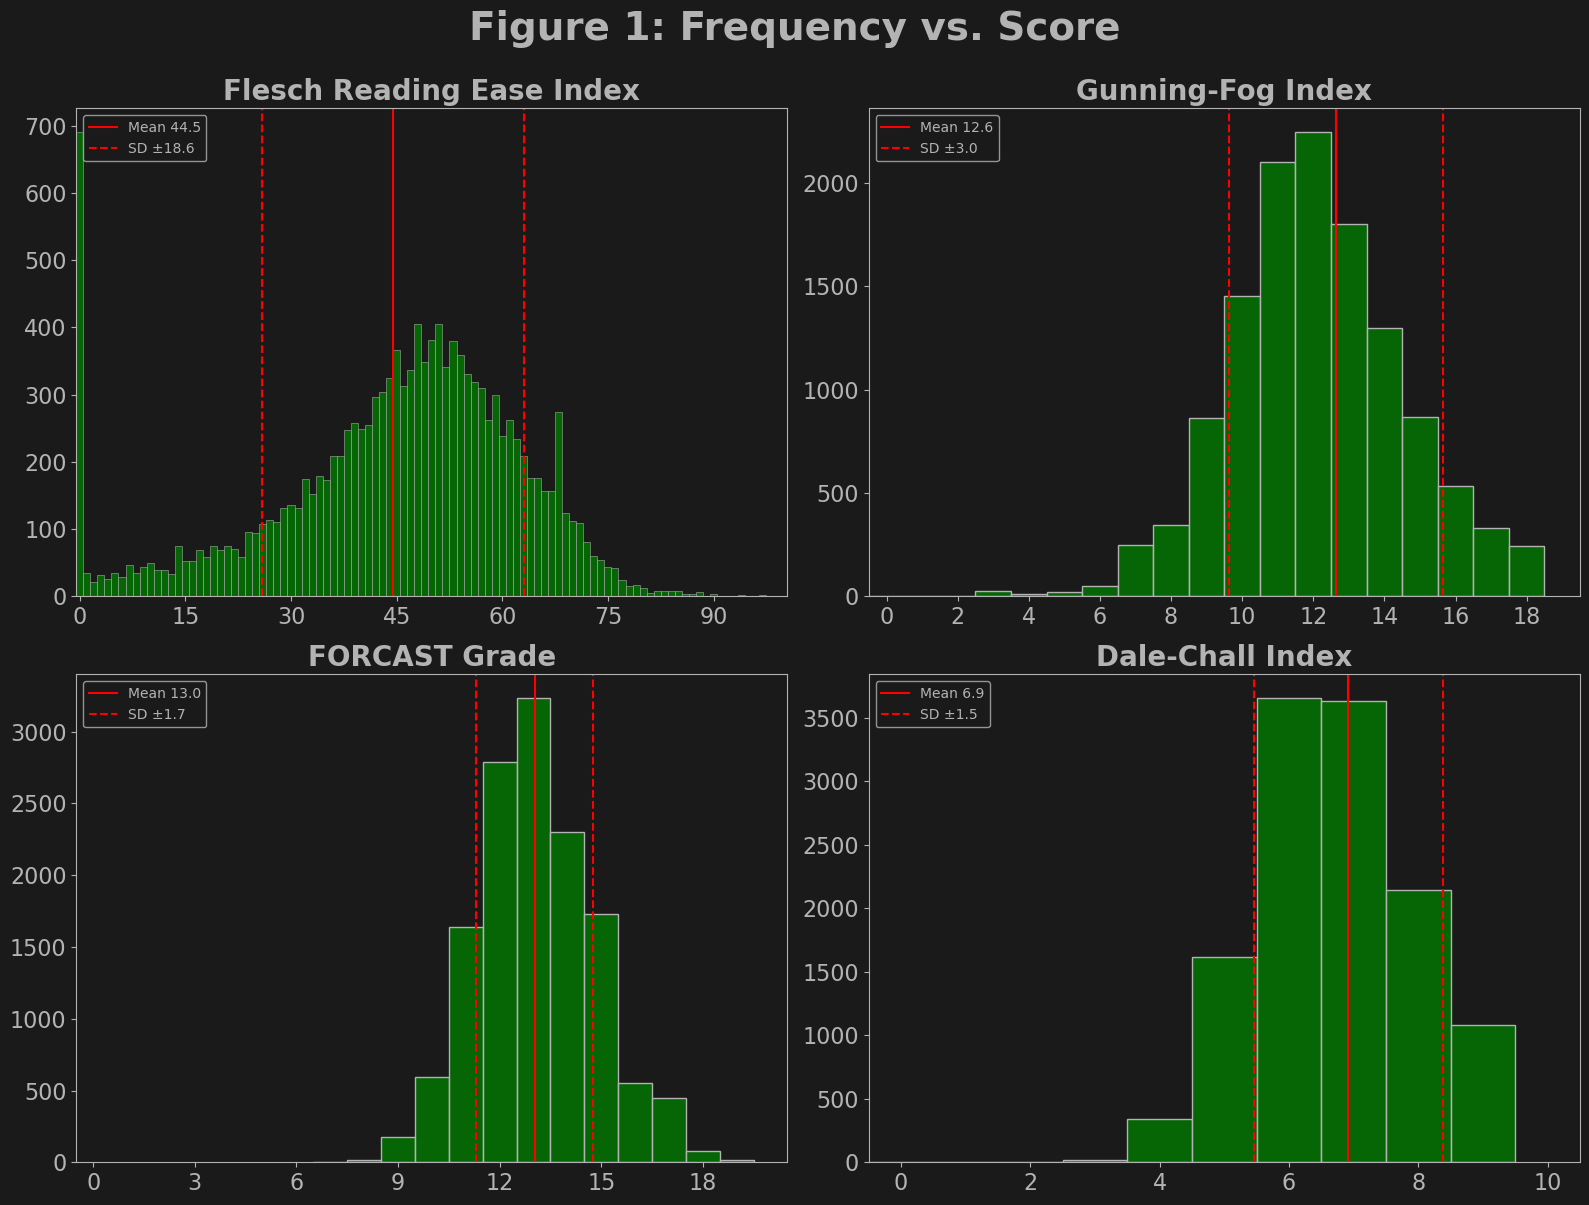

In [584]:
specs = [(df, 'Flesch Reading Ease Index', 1, True),
         (df, 'Gunning-Fog Index', 1, True,),
         (df, 'FORCAST Grade', 1, True),
         (df, 'Dale-Chall Index', 1, True)
         ]

plot_2x2_subplots(specs, title='Figure 1:')